In [42]:
### import packages
import numpy as np
import dask
import dask.array as da
from glob import glob
from h5py import File
import matplotlib.pyplot as plt
import imageio
from PIL import Image
import os
import shutil
from glob import glob
import sys
import numpy as np 
%matplotlib inline

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io
from scipy.signal import find_peaks
from pandas import read_csv

In [43]:
def dff(data, window, percentile, downsample=1):
    """
    Estimate delta-f / f_baseline with the option to downsample
    
    data : 1D numpy array
        Data to be processed
        
    window : int
        Window size for baseline estimation. If downsampling is used, window will shrink proportionally
        
    percentile : int
        Percentile used as baseline
    
    downsample : int
        Rate of downsampling used before estimating baseline. For no downsampling, use downsample=1.
    """
    
    from scipy.signal import decimate
    from scipy.ndimage.filters import percentile_filter
    from numpy import interp
    
    if downsample == 1:
        baseline = percentile_filter(data, percentile=percentile, size=window)
    else:
        data_ds = decimate(data, downsample, ftype='iir', zero_phase=True)
        # using decimate with the default filter shifts the output by ~1-2% relative to the input. 
        # correct for baseline shift by adding a small constant to data_ds
        data_ds += data.min() - data_ds.min()
        baseline_ds = percentile_filter(data_ds, percentile=percentile, size=window//downsample)
        
        baseline = interp(range(0, len(data)), range(0, len(data), downsample), baseline_ds)
    
    return (data - baseline) / baseline

In [44]:
#define file paths
struggle_path_ctrl = r'G:\My Drive\adenosine_paper\adenosine_paper_data\Fig_2E\ctrl\struggles.csv'
fluo_path_ctrl = r'G:\My Drive\adenosine_paper\adenosine_paper_data\Fig_2E\ctrl\compiled_fluo.csv'

struggle_path_prazosin = r'G:\My Drive\adenosine_paper\adenosine_paper_data\Fig_2E\prazosin\struggles.csv'
fluo_path_prazosin = r'G:\My Drive\adenosine_paper\adenosine_paper_data\Fig_2E\prazosin\compiled_fluo.csv'

struggle_path_pmca = r'G:\My Drive\adenosine_paper\adenosine_paper_data\Fig_2E\pmca\struggles.csv'
fluo_path_pmca = r'G:\My Drive\adenosine_paper\adenosine_paper_data\Fig_2E\pmca\compiled_fluo.csv'


In [77]:
#load the fluorescence data
fluo_ctrl = np.array(read_csv(fluo_path_ctrl)).T
fluo_prazosin = np.array(read_csv(fluo_path_prazosin)).T
fluo_pmca = np.array(read_csv(fluo_path_pmca)).T


In [78]:
#split the fluorescence data into time and value, and compute dff
atp_ctrl = np.zeros([int(np.shape(fluo_ctrl)[0]/2),int(np.shape(fluo_ctrl)[1])])
time_ctrl = np.zeros([int(np.shape(fluo_ctrl)[0]/2),int(np.shape(fluo_ctrl)[1])])
atp_prazosin = np.zeros([int(np.shape(fluo_prazosin)[0]/2),int(np.shape(fluo_prazosin)[1])])
time_prazosin = np.zeros([int(np.shape(fluo_prazosin)[0]/2),int(np.shape(fluo_prazosin)[1])])
atp_pmca = np.zeros([int(np.shape(fluo_pmca)[0]/2),int(np.shape(fluo_pmca)[1])])
time_pmca = np.zeros([int(np.shape(fluo_pmca)[0]/2),int(np.shape(fluo_pmca)[1])])

for i in range(np.shape(time_ctrl)[0]):
    time_ctrl[i] = fluo_ctrl[2*i]
    atp_ctrl[i] = dff(fluo_ctrl[2*i+1], 500, 10)
    
for i in range(np.shape(time_prazosin)[0]):
    time_prazosin[i] = fluo_prazosin[2*i]
    atp_prazosin[i] = dff(fluo_prazosin[2*i+1],500,10)
    
for i in range(np.shape(time_pmca)[0]):
    time_pmca[i] = fluo_pmca[2*i]
    atp_pmca[i] = dff(fluo_pmca[2*i+1],500,10)

C:\Users\kodan\AppData\Local\Temp\ipykernel_13496\273916722.py:19: DeprecationWarning: Please use `percentile_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import percentile_filter


In [79]:
# load and format struggle data
struggles_ctrl = np.array(read_csv(struggle_path_ctrl)).T
struggleList_ctrl = []    
for i in range(len(struggles_ctrl)):
    struggleFish = []
    for j in range(len(struggles_ctrl[i])):
        if not np.isnan(struggles_ctrl[i][j]):
            struggleFish.append(int(struggles_ctrl[i][j]))
    struggleList_ctrl.append(struggleFish)

struggles_prazosin = np.array(read_csv(struggle_path_prazosin)).T
struggleList_prazosin = []    
for i in range(len(struggles_prazosin)):
    struggleFish = []
    for j in range(len(struggles_prazosin[i])):
        if not np.isnan(struggles_prazosin[i][j]):
            struggleFish.append(int(struggles_prazosin[i][j]))
    struggleList_prazosin.append(struggleFish)

struggles_pmca = np.array(read_csv(struggle_path_pmca)).T
struggleList_pmca = []    
for i in range(len(struggles_pmca)):
    struggleFish = []
    for j in range(len(struggles_pmca[i])):
        if not np.isnan(struggles_pmca[i][j]):
            struggleFish.append(int(struggles_pmca[i][j]))
    struggleList_pmca.append(struggleFish)

In [83]:
#compute struggle triggered averages 
preTrigger = 11
postTrigger = 64
totalWindow = preTrigger + postTrigger

struggle_triggered_ctrl = np.zeros([len(struggleList_ctrl),totalWindow])
for i in range(len(struggleList_ctrl)):
    numStruggles = len(struggleList_ctrl[i])
    struggleTriggered = np.zeros([len(struggleList_ctrl[i]),totalWindow])
    for j in range(len(struggleTriggered)):
        struggleInd = struggleList_ctrl[i][j]
        fStart = struggleInd - preTrigger
        fEnd = struggleInd + postTrigger
        triggered = atp_ctrl[i][fStart:fEnd]
        triggered = (triggered - np.mean(triggered[0:preTrigger]))
        struggleTriggered[j] = triggered
    struggledTriggered = np.array(struggleTriggered)
    struggle_triggered_ctrl[i] = np.mean(struggleTriggered,axis=0)
    
struggle_triggered_prazosin = np.zeros([len(struggleList_prazosin),totalWindow])
for i in range(len(struggleList_prazosin)):
    numStruggles = len(struggleList_prazosin[i])
    struggleTriggered = np.zeros([len(struggleList_prazosin[i]),totalWindow])
    for j in range(len(struggleTriggered)):
        struggleInd = struggleList_prazosin[i][j]
        fStart = struggleInd - preTrigger
        fEnd = struggleInd + postTrigger
        if (fStart > 0 and fEnd < (1000 - postTrigger)):
            triggered = atp_prazosin[i][fStart:fEnd]
            triggered = (triggered - np.mean(triggered[0:preTrigger]))
            struggleTriggered[j] = triggered
    struggledTriggered = np.array(struggleTriggered)
    struggle_triggered_prazosin[i] = np.mean(struggleTriggered,axis=0)

struggle_triggered_pmca = np.zeros([len(struggleList_pmca),totalWindow])
for i in range(len(struggleList_pmca)):
    numStruggles = len(struggleList_pmca[i])
    struggleTriggered = np.zeros([len(struggleList_pmca[i]),totalWindow])
    for j in range(len(struggleTriggered)):
        struggleInd = struggleList_pmca[i][j]
        fStart = struggleInd - preTrigger
        fEnd = struggleInd + postTrigger
        if (fStart > 0 and fEnd < (1000 - postTrigger)):
            triggered = atp_pmca[i][fStart:fEnd]
            triggered = (triggered - np.mean(triggered[0:preTrigger]))
            struggleTriggered[j] = triggered
    struggledTriggered = np.array(struggleTriggered)
    struggle_triggered_pmca[i] = np.mean(struggleTriggered,axis=0)

In [92]:
#compute mean and se across fish
mean_ctrl = np.nanmean(struggle_triggered_ctrl,axis=0)
se_ctrl = np.std(struggle_triggered_ctrl,axis=0)/len(struggle_triggered_ctrl)

mean_prazosin = np.nanmean(struggle_triggered_prazosin,axis=0)
se_prazosin = np.nanstd(struggle_triggered_prazosin,axis=0)/len(struggle_triggered_prazosin)

mean_pmca = np.nanmean(struggle_triggered_pmca,axis=0)
se_pmca = np.nanstd(struggle_triggered_pmca,axis=0)/len(struggle_triggered_pmca)

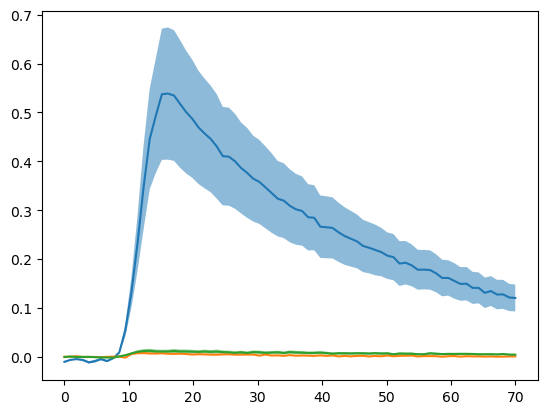

In [97]:
#generate figure
plt.figure()
time = time_ctrl[0][0:totalWindow]
plt.plot(time,mean_ctrl)
plt.fill_between(time,mean_ctrl-se_ctrl, mean_ctrl + se_ctrl,alpha = 0.5)

plt.plot(time,mean_prazosin)
plt.fill_between(time,mean_prazosin-se_prazosin, mean_prazosin + se_prazosin,alpha = 0.5)

plt.plot(time,mean_pmca)
plt.fill_between(time,mean_pmca-se_pmca, mean_pmca + se_pmca,alpha = 0.5)
plt.savefig(r'G:\My Drive\adenosine_paper\adenosine_paper_figures\Fig2\revision\Fig_2E.svg',dpi=300)

In [94]:
se_prazosin

array([1.62154229e-04, 2.01538345e-04, 2.10615004e-04, 9.66086294e-05,
       1.65436335e-04, 1.64092991e-04, 1.40222686e-04, 1.82783569e-04,
       1.86759893e-04, 1.17845581e-04, 6.59591911e-04, 4.99239261e-04,
       6.56680004e-04, 5.18634705e-04, 5.59392262e-04, 4.12301447e-04,
       5.30274953e-04, 4.01344547e-04, 4.17554372e-04, 4.33399092e-04,
       3.56659702e-04, 1.97410422e-04, 2.60638014e-04, 4.26689866e-04,
       2.59687149e-04, 2.95082666e-04, 3.36448947e-04, 1.89709768e-04,
       3.33814880e-04, 4.28793437e-04, 3.54954203e-04, 3.07952075e-04,
       2.68929387e-04, 3.18910292e-04, 3.25571561e-04, 4.27064587e-04,
       3.76093342e-04, 3.98466046e-04, 2.83371994e-04, 3.47890969e-04,
       3.53001105e-04, 2.82158299e-04, 3.96641548e-04, 4.42089153e-04,
       2.35726067e-04, 3.56416789e-04, 4.86518928e-04, 4.16562566e-04,
       3.97735156e-04, 3.60478234e-04, 5.37646883e-04, 4.54869216e-04,
       3.27762421e-04, 4.11139558e-04, 4.37433995e-04, 5.59473516e-04,
      